## Notebook under construction

## Playground to understand time dilitated networks

* Demonstrates one-dimensional (dilated) causal convolutions 
* Shows that dilated causal convolution can capture long-range dependencies

<a href="https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/1dconv_demo.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="open in colab">
</a>
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/1dconv_demo.ipynb.ipynb)

In [1]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### A simple toy example

#### Creation of the training data

We produce training data with two different time scales and a bit of noise. 

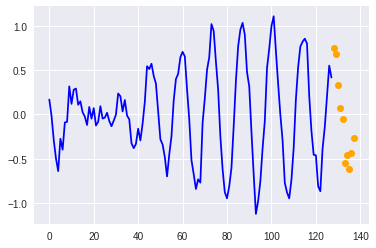

In [2]:
np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=5000, noise=0.1): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
    #d[i,:,0] = np.sin(start + np.linspace(0, 5*np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(1):
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')
  

In [3]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]
  
model1 = Sequential()
ks = 5
model1.add(layers.Conv1D(filters=32, kernel_size=ks, padding='causal', input_shape=(None, 1)))
model1.add(layers.Conv1D(filters=32, kernel_size=ks, padding='causal'))
#model1.add(layers.Conv1D(filters=1, kernel_size=ks, padding='causal'))
#model1.add(layers.Conv1D(filters=1, kernel_size=ks, padding='causal'))
if ks > 5:
  model1.add(layers.Dense(10))
model1.add(layers.Dense(1))
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
print("Shape of training data",X.shape, Y.shape)

model1.summary()
model1.compile(optimizer=Adam(), loss='mean_squared_error')


history1 = model1.fit(X[0:800], Y[0:800],
                    epochs=100,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=0)

Shape of training data (5000, 128, 1) (5000, 10, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           33        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)           0         
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


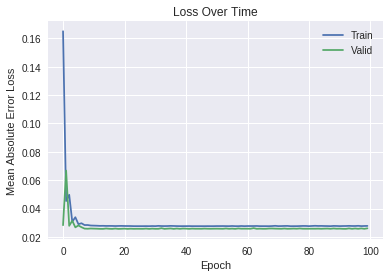

In [4]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [5]:
# Testing
X,Y = gen_data()
res = model1.predict(X) 
print('Shapes X {} Y{} res{}'.format(X.shape, Y.shape, res.shape))
print('MSE for complete look-ahead ', np.average((res[:,:,0] - Y[:,:,0])**2)) #One step look-ahead prediction
print('MSE for one step look-ahead ', np.average((res[:,0,0] - Y[:,0,0])**2)) #One step look-ahead prediction
print('MSE baseline (same as last)', np.average((X[:,-1,0] - Y[:,0,0])**2)) 
print('Std of the prediction ', np.std(res[:,0,0]))

Shapes X (5000, 128, 1) Y(5000, 10, 1) res(5000, 10, 1)
MSE for complete look-ahead  0.027793688685443747
MSE for one step look-ahead  0.04692268771795904
MSE baseline (same as last) 0.08237944487555932
Std of the prediction  0.33899066


In [0]:
# x_test,y_test = gen_data(size=1,noise=0.0)
# x_test[0,-4:,].reshape(-1),y_test.reshape(-1)

In [8]:
x_test,y_test = gen_data(size=1,noise=0.0)
model1.predict(x_test).reshape(-1),y_test.reshape(-1)

(array([ 0.05587059,  0.1571189 ,  0.25978085,  0.33820814,  0.36899698,
         0.3373509 ,  0.24190272,  0.0966256 , -0.07089943, -0.22473629],
       dtype=float32),
 array([-0.12836513,  0.10003138,  0.3247888 ,  0.49588967,  0.57174331,
         0.5291452 ,  0.3696669 ,  0.1208153 , -0.16858583, -0.43804759]))

In [0]:
# Prediction one after another
def predict_sequence(input_sequence, model, pred_steps):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps * look_ahead,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-look_ahead:,0]
        pred_sequence[0,(i * look_ahead) : ((i+1) * look_ahead),0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,look_ahead,1)], axis=1)

    return pred_sequence

(-1, 1)

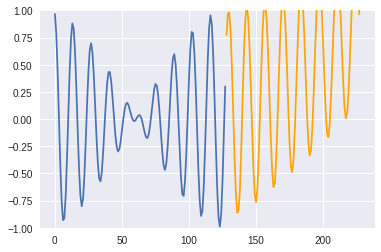

In [16]:
pred_steps = 10
x_test,y_test = gen_data(size=1,noise=0.0)
preds = predict_sequence(x_test, model1, pred_steps)
plt.plot(range(0,len(x_test[0])),x_test[0,:,0])
plt.plot(range(len(x_test[0]),len(x_test[0])+len(preds[0])),preds[0,:,0],color='orange')
#plt.plot(range(len(x_test[0]),len(x_test[0])+len(y_test[0])),y_test[0,:,0],color='blue',linestyle='dashed')
plt.ylim((-1,1))

In [11]:
modeldil = Sequential()
fi = 10
ks =  5 
modeldil.add(layers.Conv1D(filters=fi, kernel_size=ks, padding='causal', dilation_rate=1, input_shape=(None, 1)))
modeldil.add(layers.Conv1D(filters=fi, kernel_size=ks, padding='causal', dilation_rate=2))
modeldil.add(layers.Conv1D(filters=fi, kernel_size=ks, padding='causal', dilation_rate=4))
modeldil.add(layers.Conv1D(filters=fi, kernel_size=ks, padding='causal', dilation_rate=8))
#modeldil.add(layers.Conv1D(filters=fi, kernel_size=ks, padding='causal', dilation_rate=16))
# modeldil.add(layers.Conv1D(filters=fi, kernel_size=ks, padding='causal', dilation_rate=32))
# modeldil.add(layers.Conv1D(filters=fi, kernel_size=ks, padding='causal', dilation_rate=64))

if fi > 1:
  modeldil.add(layers.Dense(2*fi))
  modeldil.add(layers.Dense(1))
modeldil.add(Lambda(slice, arguments={'slice_length':look_ahead}))

modeldil.summary()
modeldil.compile(optimizer=Adam(),
              loss='mean_absolute_error',
              #loss='mean_squared_error'
                )


print(X.shape, Y.shape)
histdil = modeldil.fit(X[0:800], Y[0:800],
                    epochs=200,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]), verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 10)          60        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 10)          510       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 10)          510       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 10)          510       
_________________________________________________________________
dense_2 (Dense)              (None, None, 20)          220       
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           21        
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1)           0         
Total para

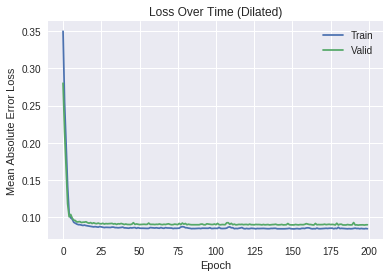

In [12]:
plt.plot(histdil.history['loss'])
plt.plot(histdil.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time (Dilated)')
plt.legend(['Train','Valid'])

In [13]:
# Testing
X,Y = gen_data()
res = modeldil.predict(X) 
print('MSE for one step look-ahead ', np.average((res[:,0,0] - Y[:,0,0])**2)) #One step look-ahead prediction
print('MSE baseline (same as last)', np.average((X[:,-1,0] - Y[:,0,0])**2)) 
print('Std of the prediction ', np.std(res[:,0,0]))

MSE for one step look-ahead  0.011831878292344363
MSE baseline (same as last) 0.08222995454486165
Std of the prediction  0.34809178


(-1, 1)

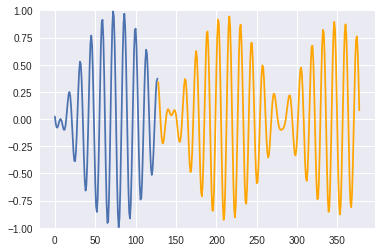

In [26]:
pred_steps = 25
x_test,y_test = gen_data(size=1,noise=0.0)
preds = predict_sequence(x_test, modeldil, pred_steps)
plt.plot(range(0,len(x_test[0])),x_test[0,:,0])
plt.plot(range(len(x_test[0]),len(x_test[0])+len(preds[0])),preds[0,:,0],color='orange')
#plt.plot(range(len(x_test[0]),len(x_test[0])+len(y_test[0])),y_test[0,:,0],color='blue',linestyle='dashed')
plt.ylim((-1,1))

### Understanding Causal Padding

Below is a simple example to show that convolutions is made causal by  padding.

We use a single 1 dimensional kernel 1,2 and as input the sequence 10,20,30. Causal padding simply does the following

00,10,20,30
  1,2

resulting in
 
 20, 50, 80

In [0]:
model = Sequential()
model.add(Conv1D(filters=1, 
                 kernel_size=2, 
                 padding='causal', 
                 dilation_rate=1,
                 use_bias=False,
                 input_shape=(3, 1))
         )

model.summary()

In [0]:
#print(model.get_weights())
model.set_weights([np.asarray([[[1]],[[2]]])])
print(model.get_weights())

In [0]:
x_in = np.reshape(np.linspace(10,30,3), (1,3,1))
print(x_in)
model.predict(x_in)